In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.utils import pretty_lat, pretty_lon, ProgressStatus, plot_n_steps_of_area_from_nc_file
from tempfile import TemporaryDirectory

In [2]:
from station.data_submission import DataSubmission
from station.station import StationData

from train_station_twin.training_executor import TrainingExecutor
from infilling.evaluation_executor import EvaluationExecutor
from infilling.infilling_writer import InfillingWriter

from era5.era5_for_station import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_download_hook import Era5DownloadHook
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
# Marshall Station but passing lat lon and year month to the hook 
# Hook provides different methods to download data for a station, + bounding box
# donwload hous in day, months, years
# cds.api retireive 

era5_hook = Era5DownloadHook(lat=39.9496, lon=-105.196)

years = 2020
months = 6

# Download data for a station months
era5_hook.download_month(years, months, "ERA5hook_marshall")



Using URL: https://cds-beta.climate.copernicus.eu/api


2024-11-04 11:05:52,358 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-04 11:05:52,358 INFO Request ID is ab8438f4-ffb9-43ff-b5eb-fc9cf05e7a80
2024-11-04 11:05:52,440 INFO status has been updated to accepted


KeyboardInterrupt: 

In [ ]:
# Marshall Station but passing lat lon and year month to the hook 

era5_hook = Era5DownloadHook(lat=39.9496, lon=-105.196)

years = 2020
months = 6

era5_hook.download_month(years, months, "ERA5hook_marshall")


In [4]:
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc

folder = "ERA5hook_marshall"
era5_target_file_path = f"{folder}/era5.nc"

# Conversion
# converts grib to nc 
# using cdo command -f nc4 copy result is 0.25x0.25grid 
# renames variables 
# merges files


Era5DataFromGribToNc(
    folder_path=folder,
    era5_target_file_path=era5_target_file_path
)




Found 2020_6.grib
Merging files...



cdo    mergetime (Abort): Outputfile ERA5hook_marshall/era5.nc already exists!


CalledProcessError: Command 'cdo mergetime /var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmpalj1undq/*.nc ERA5hook_marshall/era5.nc' returned non-zero exit status 1.

In [5]:
ds = xr.open_dataset("ERA5hook_marshall/era5.nc")
ds


<xarray.Dataset> Size: 1MB
Dimensions:  (time: 720, lon: 9, lat: 9)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
  * lon      (lon) float64 72B 253.8 254.1 254.3 254.6 ... 255.3 255.6 255.8
  * lat      (lat) float64 72B 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2 38.95
Data variables:
    t2m      (time, lat, lon) float32 233kB ...
    tp       (time, lat, lon) float32 233kB ...
    u10      (time, lat, lon) float32 233kB ...
    v10      (time, lat, lon) float32 233kB ...
    sp       (time, lat, lon) float32 233kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Nov 01 16:03:46 2024: cdo mergetime /var/folders/lj/q1n...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

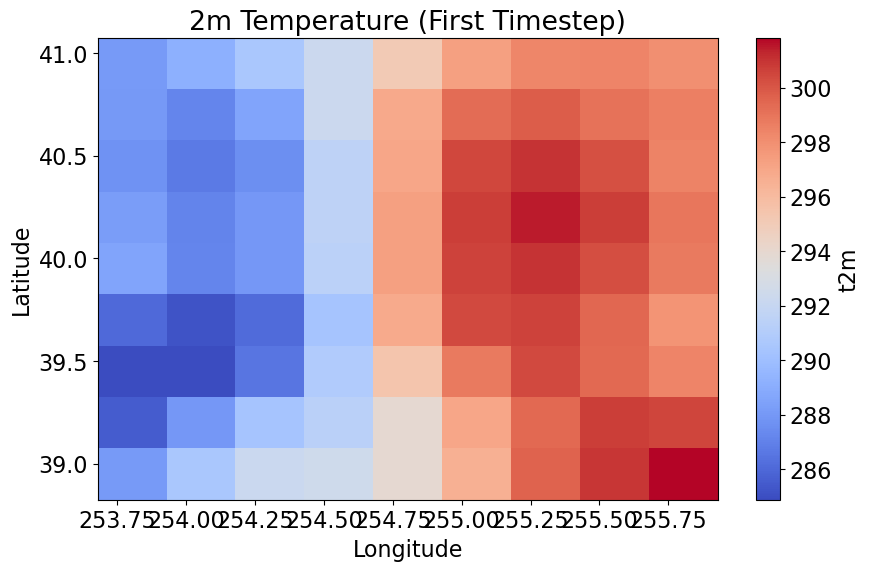

In [8]:
# Select the first timestep of 't2m' and plot it
t2m_first_timestep = ds['t2m'].isel(time=-3)

# Plotting
plt.figure(figsize=(10, 6))
t2m_first_timestep.plot(cmap='coolwarm')
plt.title("2m Temperature (First Timestep)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## GPT explanation

Extracting Vienna_station_name...


100%|██████████| 1857/1857 [01:22<00:00, 22.51it/s]


displaying lon: 16.3609
as 16.361


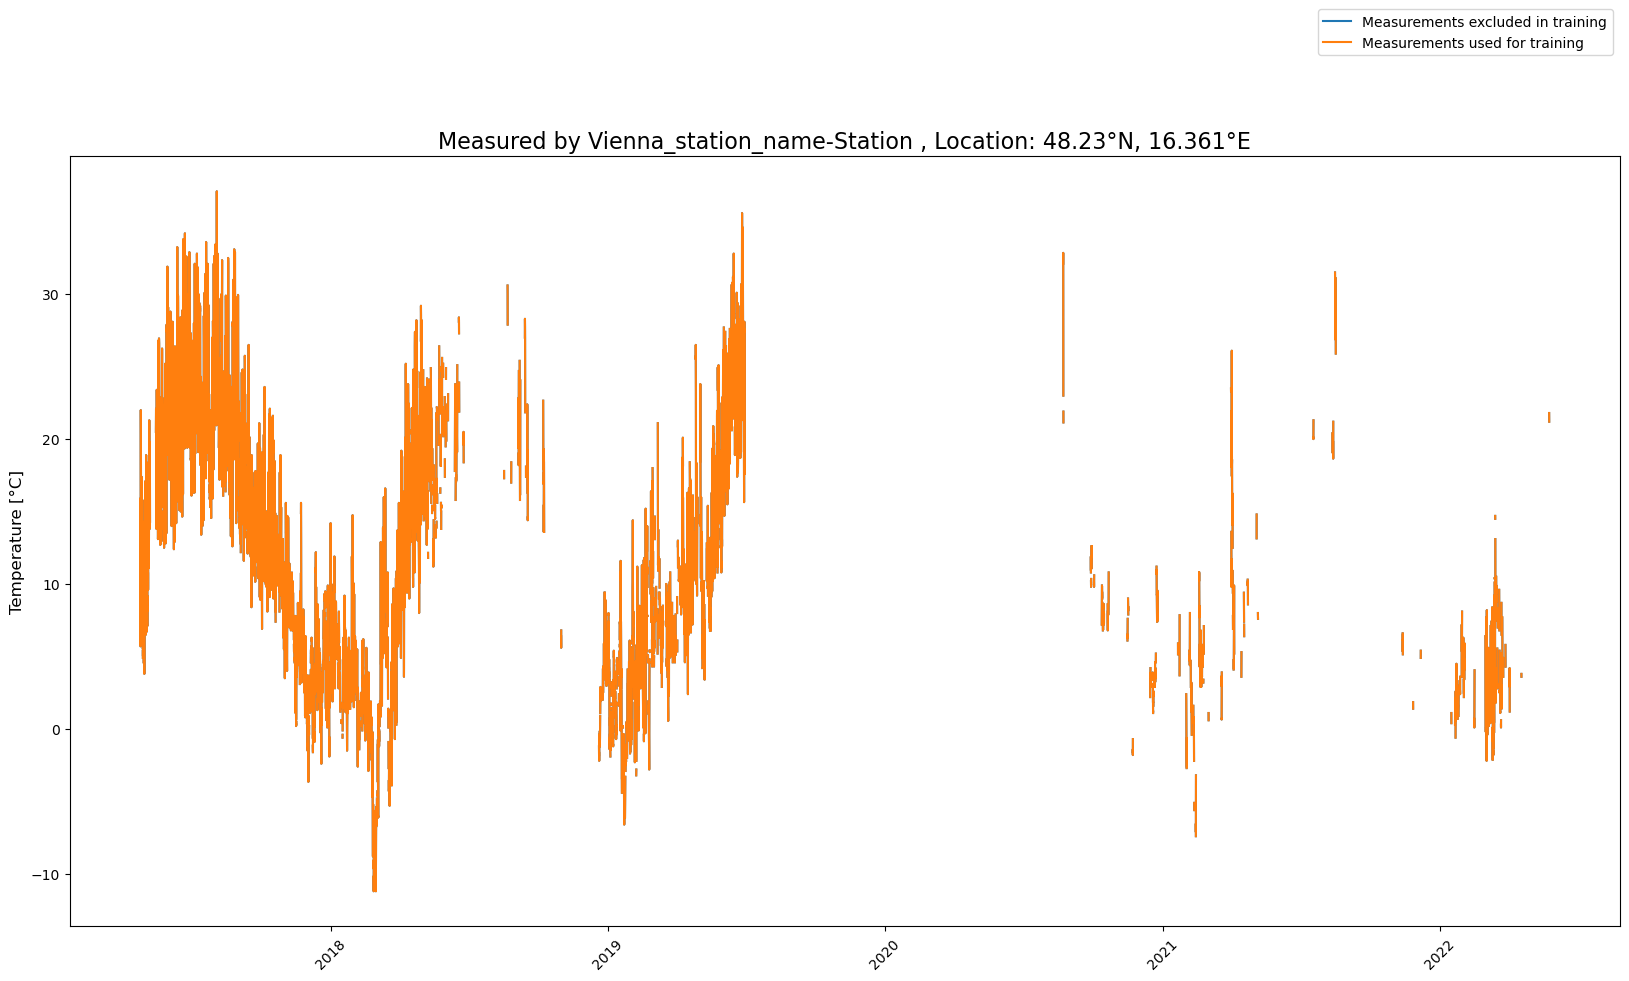

In [8]:
# Initialize the station data
# Processes all dat files, extracts metadata cleans data uses DattoNxConverter
vienna_station = StationData(
    name='Vienna_station_name',
    folder_path='measurements/Vienna',
    #mask_years=[2020]  # Optionally mask out certain years
)

In [4]:
# Initialize the ERA5 download hook
era5_hook = Era5DownloadHook(lat=vienna_station.metadata['latitude'], lon=vienna_station.metadata['longitude'])

Using URL: https://cds-beta.climate.copernicus.eu/api


In [13]:
grib_dir_path = 'measurements/Testing'

# Download ERA5 data for the station
era5_downloader = DownloadEra5ForStation(vienna_station, grib_dir_path, era5_hook)
era5_downloader.execute()

Downloading... 2017


2024-11-01 16:30:05,304 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-01 16:30:05,304 INFO Request ID is c37bbc55-2f4e-4bb3-a87b-6d28b473481b
2024-11-01 16:30:05,373 INFO status has been updated to accepted
2024-11-01 16:30:09,346 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attemps 1 of 500
Retrying in 120 seconds
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attemps 1 of 500
Retrying in 120 seconds
2024-11-01 21:18:05,920 INFO status has been updated to failed


HTTPError: 400 Client Error: Bad Request for url: https://cds.climate.copernicus.eu/api/retrieve/v1/jobs/c37bbc55-2f4e-4bb3-a87b-6d28b473481b/results
The job has failed.
The job failed with: TypeError

In [9]:
# bypassing the download of the data

from era5.era5_for_station import Era5ForStationCropper
from station.station import StationData

# Paths for ERA5 data
merged_era5_nc_path = 'ERA5_DRKZ/vienna_t2m_2017-2024_data.nc'       # Existing NetCDF ERA5 data
cropped_era5_nc_path = 'ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc'    # Output path for cropped ERA5 data

# Initialize the cropper
era5_cropper = Era5ForStationCropper(
    station=vienna_station,
    era5_path=merged_era5_nc_path,
    era5_target_path=cropped_era5_nc_path
)

# Execute cropping
era5_cropper.execute()


Latitudes are sorted in ascending order.
Lat:  48.2303
Lon:  16.3609
search: 16.3609  in asc_lon_list: [14.   14.25 14.5  14.75 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75
 17.   17.25 17.5  17.75 18.  ]
nearest_lon_idx: 9
nearest_lat_idx: 9
nearest_lat: 48.25
nearest_lon: 16.25
nearest lon is smaller
nearest lat is bigger
crop_lon_idx_min: 6
crop_lon_idx_max: 13
crop_lat_idx_min: 5
crop_lat_idx_max: 12
Lon values after cropping: [15.5  15.75 16.   16.25 16.5  16.75 17.   17.25]
Lat values after cropping: [47.25 47.5  47.75 48.   48.25 48.5  48.75 49.  ]
Era5 for station cropped and exported to: ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc


In [6]:
cropped_data = xr.open_dataset('ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc')
print(cropped_data)

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12477, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lon      (lon) float64 64B 15.5 15.75 16.0 16.25 16.5 16.75 17.0 17.25
  * lat      (lat) float64 64B 47.25 47.5 47.75 48.0 48.25 48.5 48.75 49.0
Data variables:
    var167   (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Oct 30 22:21:53 2024: cdo mergetime /home/k/k202207/ERA...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...


In [7]:
vienna_station.df

,ir_light,tas,vis_light,uv_light
datetime,,,,
2017-04-24 14:00:00,658.0,288.05,323.0,35.0
2017-04-24 15:00:00,607.0,288.75,316.0,32.0
2017-04-24 16:00:00,511.5,289.05,299.5,23.0
2017-04-24 17:00:00,364.5,288.55,276.0,10.0
2017-04-24 18:00:00,253.0,286.80,261.0,2.0
...,...,...,...,...
2022-04-18 02:00:00,252.5,276.75,261.0,NaN
2022-05-24 12:00:00,3174.0,295.05,569.0,167.0
2022-05-24 14:00:00,2275.0,294.95,486.0,123.0


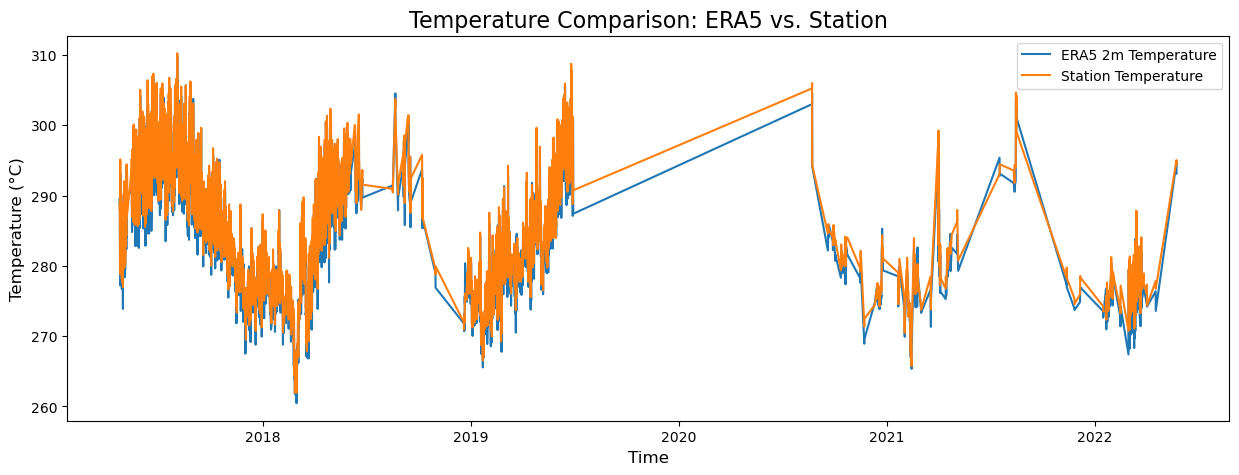

In [8]:
# Load the cropped ERA5 data
era5_data = xr.open_dataset('ERA5_DRKZ/vienna_t2m_2017-2024_data_cropped_era5.nc')

# Extract the 2m temperature variable (assuming it's named 'var167')
era5_t2m = era5_data['var167'].sel(lat = 48.2303, lon = 16.3609 , method="nearest")
era5_t2m_celsius = era5_t2m  # Assuming already in Celsius

# Extract station temperature data (assuming 'tas' is in Kelvin)
station_tas_celsius = vienna_station.df['tas']


# Convert station_tas_celsius to xarray.DataArray
station_tas_da = xr.DataArray(
    station_tas_celsius.values,
    coords=[station_tas_celsius.index],
    dims=["time"],
    name="tas_celsius"
)

# Align using xr.align
era5_aligned, station_aligned = xr.align(era5_t2m_celsius, station_tas_da, join='inner')

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(era5_aligned.time, era5_aligned, label='ERA5 2m Temperature')
plt.plot(station_aligned.time, station_aligned, label='Station Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Comparison: ERA5 vs. Station')
plt.legend()
plt.show()


In [9]:
# Initialize StationData


# Find missing hours
missing_hours = vienna_station.find_gaps()
print(f"Number of missing hours: {len(missing_hours)}")
print("Missing Hours:", missing_hours)


Number of missing hours: 32077
Missing Hours: [Timestamp('2017-04-24 07:00:00'), Timestamp('2017-04-24 08:00:00'), Timestamp('2017-04-24 09:00:00'), Timestamp('2017-04-24 10:00:00'), Timestamp('2017-04-24 11:00:00'), Timestamp('2017-04-24 12:00:00'), Timestamp('2017-04-24 13:00:00'), Timestamp('2017-04-27 06:00:00'), Timestamp('2017-04-27 17:00:00'), Timestamp('2017-04-27 23:00:00'), Timestamp('2017-04-28 02:00:00'), Timestamp('2017-04-28 03:00:00'), Timestamp('2017-04-28 06:00:00'), Timestamp('2017-04-28 14:00:00'), Timestamp('2017-04-29 02:00:00'), Timestamp('2017-04-30 22:00:00'), Timestamp('2017-05-01 01:00:00'), Timestamp('2017-05-01 02:00:00'), Timestamp('2017-05-01 03:00:00'), Timestamp('2017-05-01 04:00:00'), Timestamp('2017-05-03 20:00:00'), Timestamp('2017-05-05 20:00:00'), Timestamp('2017-05-07 01:00:00'), Timestamp('2017-05-07 16:00:00'), Timestamp('2017-05-07 17:00:00'), Timestamp('2017-05-07 18:00:00'), Timestamp('2017-05-07 19:00:00'), Timestamp('2017-05-07 20:00:00'), T

In [10]:
# Get all available months grouped by year
years_by_months = vienna_station.get_all_months_in_df()
print(years_by_months)
# Example Output: {2019: [1, 2, 3], 2021: [5, 6, 7, 8]}


{2017: [4, 5, 6, 7, 8, 9, 10, 11, 12], 2018: [1, 2, 3, 4, 5, 6, 8, 9, 10, 12], 2019: [1, 2, 3, 4, 5, 6], 2020: [8, 9, 10, 11, 12], 2021: [1, 2, 3, 4, 5, 7, 8, 11, 12], 2022: [1, 2, 3, 4, 5]}


In [11]:
# Export station data to NetCDF
target_dir = 'measurements/Testing'
nc_file_path = vienna_station.export_as_nc(target_directory=target_dir)
print(f"Station data exported to: {nc_file_path}")


(12477,) hourly temperature values in dataframe
Saving to measurements/Testing/vienna_station_name.nc
Station data exported to: measurements/Testing/vienna_station_name.nc


In [15]:
# loading exported nc file again as station data
# Path to your exported station NetCDF file
station_nc_path = 'measurements/Testing/vienna_station_name.nc'

# Load the NetCDF dataset
station_ds = xr.open_dataset(station_nc_path)

# Inspect the dataset
print(station_ds)

<xarray.Dataset> Size: 200kB
Dimensions:  (time: 12477, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lat      (lat) float64 8B 48.23
  * lon      (lon) float64 8B 16.36
Data variables:
    tas      (time, lat, lon) float64 100kB ...


<xarray.Dataset> Size: 77MB
Dimensions:  (time: 66456, lon: 17, lat: 17)
Coordinates:
  * time     (time) datetime64[ns] 532kB 2017-01-01 ... 2024-07-31T23:00:00
  * lon      (lon) float64 136B 14.0 14.25 14.5 14.75 ... 17.25 17.5 17.75 18.0
  * lat      (lat) float64 136B 46.0 46.25 46.5 46.75 ... 49.25 49.5 49.75 50.0
Data variables:
    t2m      (time, lat, lon) float32 77MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Oct 30 22:21:53 2024: cdo mergetime /home/k/k202207/ERA...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [26]:
# Open the ERA5 dataset
ds = xr.open_dataset("ERA5_DRKZ/vienna_t2m_2017-2024_data.nc")
# Define the variable mapping
variable_mapping = {
    'var167': 'tas',  # 2 metre temperature
    'var228': 'tp',   # Total precipitation
    'var165': 'u10',  # 10 metre U wind component
    'var166': 'v10',  # 10 metre V wind component
    'var134': 'sp',   # Surface pressure
    # Add other mappings as needed
}
variables_to_rename = {old: new for old, new in variable_mapping.items() if old in ds.variables}
ds = ds.rename(variables_to_rename)
# Save the renamed dataset back to the same path
ds.to_netcdf("ERA5_DRKZ/vienna_t2m_2017-2024_data_renamed.nc")

In [3]:
from station.station import StationData
from era5.era5_download_hook import Era5DownloadHook
from era5.era5_for_station import DownloadEra5ForStation, Era5ForStationCropper
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc


from utils.utils import FillAllTasWithValuesInNcFile, ProgressStatus

from crai.climatereconstructionai import train

import subprocess
import asyncio
import tempfile
import os
import shutil
import sys
import pty

import xarray as xr
import re

import numpy as np
import time

class TrainingExecutor_era5():

    def __init__(self, station: StationData, progress: ProgressStatus, iterations, local=False, era5_path=None):
        self.station = station
        self.era5_path_provided = era5_path is not None # updated by me
        self.input_era5_path = era5_path if self.era5_path_provided else None  # Stores the provided path
        assert station.name is not None
        assert station.metadata is not None
        assert station.metadata.get("latitude") is not None
        assert station.metadata.get("longitude") is not None
        if local:
            # make a temporary directory in the current working directory with the station name and the current time as YYYY-MM-DD_HH-MM-SS
            temp_path = f'./executed_trainings/{station.name}_{time.strftime("%Y%m%d-%H%M")}'
            os.mkdir(temp_path)
            self.target_dir = tempfile.TemporaryDirectory(dir=temp_path, prefix='target_')
            self.temp_dir = tempfile.TemporaryDirectory(dir=temp_path, prefix='temp_')
            self.model_dir = tempfile.TemporaryDirectory(dir=temp_path, prefix='model_')
            self.log_dir = tempfile.TemporaryDirectory(dir=temp_path, prefix='log_')
        else:
            self.target_dir = tempfile.TemporaryDirectory()
            self.temp_dir = tempfile.TemporaryDirectory()
            self.model_dir = tempfile.TemporaryDirectory()
            self.log_dir = tempfile.TemporaryDirectory()

        self.era5_file_name = "era5_merged.nc"
        self.expected_output_file_name = "cleaned.nc"
        self.subfolder_name = "train"
        self.model_dir_subfolder_name = "ckpt"

        self.prepare_target_directory()
        self.station_nc_file_path = self.station.export_as_nc(
            target_directory=self.target_dir.name + '/' + self.subfolder_name
        )

        # Define the target ERA5 path
        self.era5_path = os.path.join(self.target_dir.name, self.subfolder_name, self.era5_file_name)

        self.expected_output_path = os.path.join(self.target_dir.name, self.subfolder_name, self.expected_output_file_name)
        self.train_args_path = os.path.join(self.target_dir.name, 'train_args.txt')

        self.progress = progress
        self.total_iterations = iterations

    def execute(self):
        if not self.era5_path_provided:
            self.get_era5_for_station()
        else:
            # Ensure the target directory exists
            os.makedirs(os.path.dirname(self.era5_path), exist_ok=True)
            
            # Debugging Statements (Optional but recommended)
            print(f"Copying ERA5 data from '{self.input_era5_path}' to '{self.era5_path}'")
            
            # Copy the provided ERA5 data to the target path
            shutil.copy(self.input_era5_path, self.era5_path)
            
            # Transform the copied ERA5 data
            self.transform_era5_for_station()

        self.progress.update_phase("Preparing Training Set")
        self.transform_station_to_expected_output()
        self.copy_train_folder_as_val_folder()
        path = self.get_train_args_txt()
        model_dir_path = self.crai_train(path)
        self.progress.update_phase("")
        return self.make_zip_folder(model_dir_path)
    
    def get_sbatch_script(self):

        slurm_logs_dir = os.path.join(self.temp_dir.name, 'slurm_logs')
        os.makedirs(slurm_logs_dir, exist_ok=True)

        # make subdirectory for slurm logs
        user_home_dir = os.path.expanduser("~")
        script_txt = f'''#!/usr/bin/env bash

#SBATCH -J crai-train
#SBATCH --output {self.temp_dir.name}/slurm_logs/crai_crai-train_%j.log
#SBATCH -p gpu
#SBATCH -A bm1159
#SBATCH --time=12:00:00
#SBATCH --mem=485G
#SBATCH --exclusive
#SBATCH --constraint a100_80

cd {os.getcwd()}
module load python3

# Initialize Conda (add this line)
eval "$(conda shell.bash hook)"

conda activate {user_home_dir}/.conda/envs/crai

python -m climatereconstructionai.train --load-from-file {self.get_train_args_txt()}
'''
        # save script to file
        script_path = self.temp_dir.name + '/train_script.sh'
        with open(script_path, 'w') as f:
            f.write(script_txt)
        subprocess.run(['chmod', '+x', script_path])
        return script_path

    def execute_with_sbatch(self):
        # unsing already cropped data
        if not self.era5_path_provided:
            self.get_era5_for_station()
        else: 
            temp_path = os.path.join(self.target_dir.name, self.temp_dir.name, self.era5_file_name)

            shutil.copy(self.era5_path, temp_path)        
            self.transform_station_to_expected_output()
        self.copy_train_folder_as_val_folder()

        result = subprocess.run(['sbatch', self.get_sbatch_script()], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # Check if the command executed successfully
        if result.returncode == 0:
            # Extract the job ID from the output
            output_lines = result.stdout.splitlines()
            if output_lines:
                # The job ID is typically in the first line of the output
                job_id_line = output_lines[0]
                # Split the line by whitespace and get the last element (job ID)
                job_id = job_id_line.split()[-1]
                return job_id
            else:
                print("No output received from sbatch command.")
                return
        else:
            print("Error submitting batch job:", result.stderr.strip())
            return

    def transform_era5_for_station(self):
        # Debugging Statements (Optional)
        print(f"Transforming ERA5 data at '{self.era5_path}'")

        # Initialize the cropper with the correct paths
        cropper = Era5ForStationCropper(
            station=self.station,
            era5_path=self.era5_path,  # Ensure this is the correct path
            era5_target_path=self.era5_path
        )

        # Execute the cropping process
        cropper.execute()
        cropper.cleanup()


    def get_era5_for_station(self):
        era5_hook = Era5DownloadHook(lat=self.station.metadata.get("latitude"),
                                     lon=self.station.metadata.get("longitude"))

        temp_grib_dir = tempfile.TemporaryDirectory()

        DownloadEra5ForStation(
            station=self.station,
            grib_dir_path=temp_grib_dir.name,
            hook=era5_hook,
            progress=self.progress
        )

        era5_temp_path = self.temp_dir.name + '/' + self.era5_file_name

        Era5DataFromGribToNc(
            temp_grib_dir.name,
            era5_target_file_path=era5_temp_path
        )

        temp_grib_dir.cleanup()

        cropper = Era5ForStationCropper(
            station=self.station,
            era5_path=era5_temp_path,
            era5_target_path=self.era5_path
        )

        cropper.execute()
        cropper.cleanup()


    def transform_station_to_expected_output(self):

        station_nc = xr.open_dataset(self.station_nc_file_path)
        era5_nc = xr.open_dataset(self.era5_path)

        # assert the time axis is the same
        try:
            assert all(station_nc.time.values == era5_nc.time.values)
        except Exception as e:
            print("Time axis is not the same")
            print("Station time axis:", station_nc.time.values)
            print("ERA5 time axis:", era5_nc.time.values)
            print("Difference:", set(station_nc.time.values) - set(era5_nc.time.values), "or",
                    set(era5_nc.time.values) - set(station_nc.time.values))
            # raise e

        FillAllTasWithValuesInNcFile(
            values=station_nc.tas.values.flatten(),
            original_path=self.era5_path,
            save_to_path=self.expected_output_path
        )

    def get_train_args(self):
        return f"""
            --data-root-dir {self.target_dir.name}
            --data-names {self.era5_file_name},{self.expected_output_file_name}
            --data-types tas,tas
            --n-target-data 1
            --encoding-layers 3
            --pooling-layers 0
            --device cpu
            --n-filters 18
            --out-channels 1
            --snapshot-dir {self.model_dir.name}
            --n-threads 0
            --max-iter {self.total_iterations}
            --log-interval {self.total_iterations // 100}
            --eval-timesteps 0,1
            --loss-criterion 3
            --log-dir {self.log_dir.name}
            --normalize-data
        """.strip()

    def get_train_args_txt(self):
        train_args_path = self.target_dir.name + '/train_args.txt'
        train_args = self.get_train_args()
        print("train args:", train_args)
        with open(self.train_args_path, 'w') as f:
            f.write(train_args)
        return self.train_args_path

    def crai_train(self, train_args_path):
        print("Active conda environment:", os.environ.get('CONDA_DEFAULT_ENV'))
        self.progress.update_phase("Training")
        self.progress.folder_path = os.path.join(self.model_dir.name, "images")

        try:
            # Clear sys.argv to remove any unexpected arguments that Jupyter might have set
            sys.argv = [sys.argv[0]]  # Keep only the script name

            # Call the train function directly
            train(train_args_path)
            
        except subprocess.CalledProcessError as e:
            raise Exception("Error during training") from e

        return self.model_dir.name


    

    def get_path_of_final_model(self):
        # assert final is there
        final_model_default_path = self.model_dir.name + '/' + self.model_dir_subfolder_name + '/final.pth'
        human_friendly_path = final_model_default_path.replace('final.pth', f'{self.station.name}-model-{self.total_iterations}.pth')
        try:
            assert os.path.exists(final_model_default_path)
            shutil.copy(final_model_default_path, human_friendly_path)
        except AssertionError:
            assert os.path.exist(human_friendly_path), "Final model not found" + str(os.listdir(self.model_dir.name + '/' + self.model_dir_subfolder_name))
        return human_friendly_path

    def make_zip_folder(self, folder_path):
        
        # Create a zip archive of the model directory
        shutil.make_archive(folder_path, 'zip', folder_path)
        
        # Define the zip file name
        zip_file_name = f"{self.station.name}_model.zip"
        new_zip_file_path = os.path.join(self.target_dir.name, zip_file_name)
        
        # Move the zip file to the target directory with the desired name
        shutil.move(f"{folder_path}.zip", new_zip_file_path)
        
        return new_zip_file_path


    def cleanup(self):
        self.target_dir.cleanup()
        self.temp_dir.cleanup()
        self.log_dir.cleanup()

    def prepare_target_directory(self):
        os.makedirs(self.target_dir.name + '/' + self.subfolder_name)
        return self.target_dir.name + '/' + self.subfolder_name

    def copy_train_folder_as_val_folder(self):
        shutil.copytree(
            self.target_dir.name + '/' + self.subfolder_name,
            self.target_dir.name + '/val'
        )
        return self.target_dir.name + '/val'


Extracting Vienna...


  0%|          | 0/1857 [00:00<?, ?it/s]

100%|██████████| 1857/1857 [01:35<00:00, 19.40it/s]


displaying lon: 16.3609
as 16.361


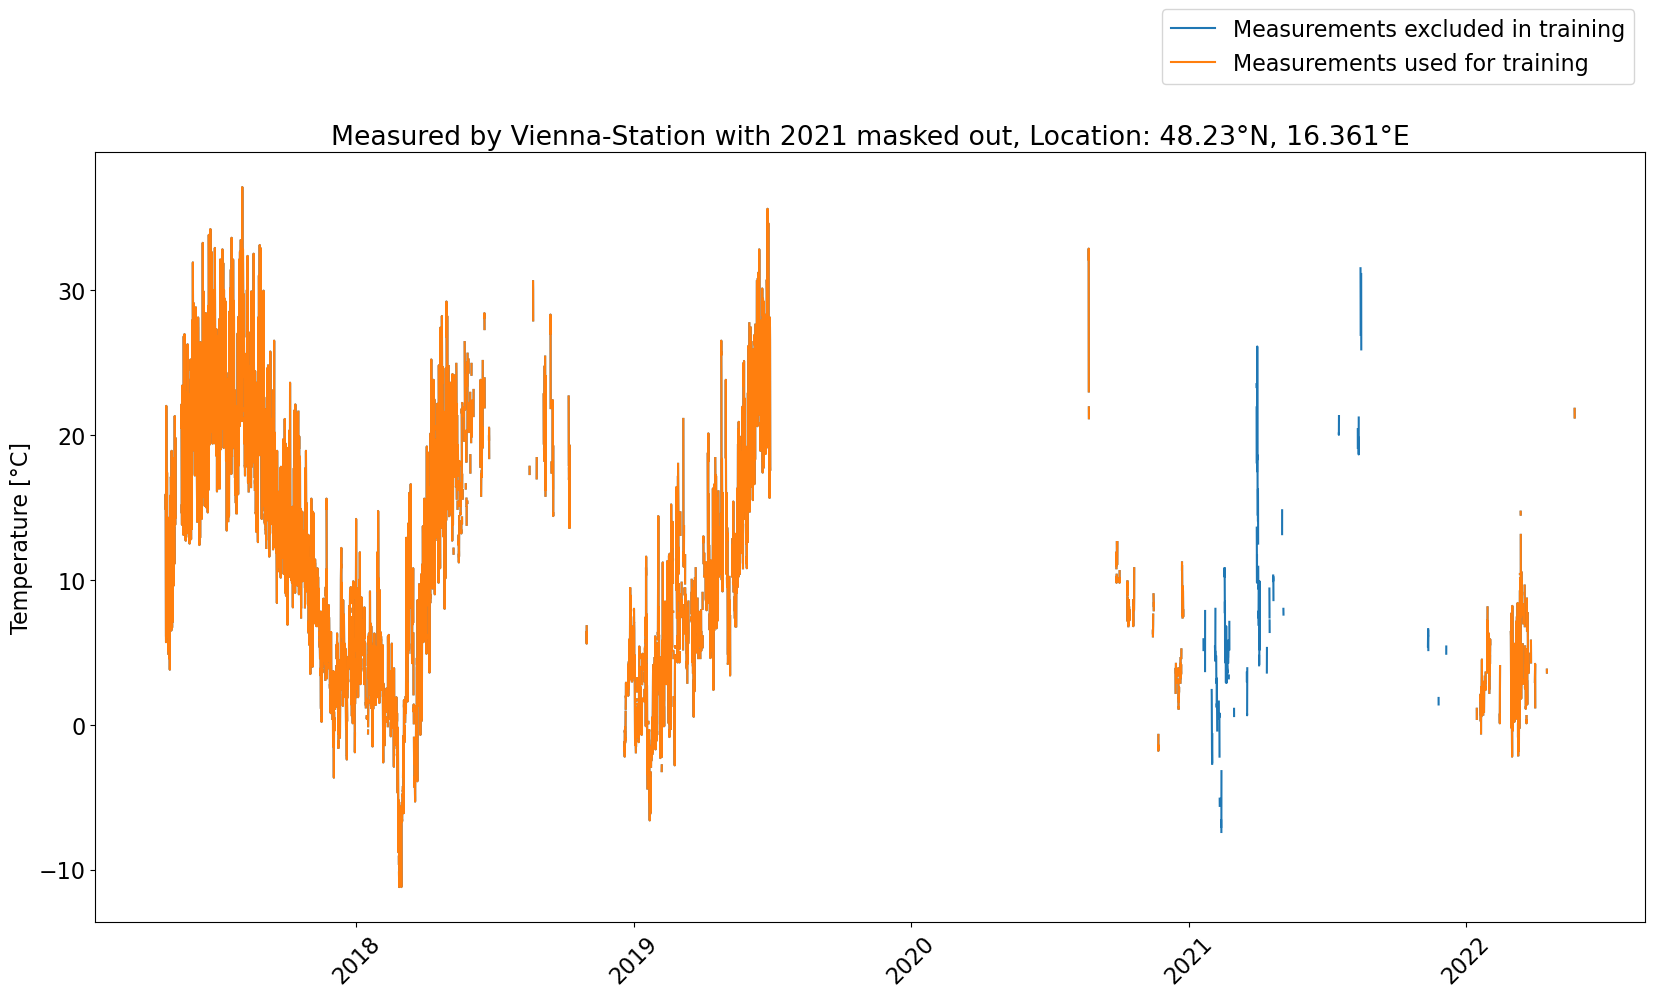

In [4]:
from station.data_submission import DataSubmission


station_submission = DataSubmission(name="Vienna", mask_years=[2021])
station_submission.measurement_dir_path = "measurements/Vienna"

station_submission.initialize_station()

In [5]:

training = TrainingExecutor_era5(
    station = station_submission.station,
    progress = station_submission.progress,
    iterations = 10000,
    local = True,
    era5_path="ERA5_DRKZ/vienna_t2m_2017-2024_data_renamed.nc"
)
training.execute()

(12134,) hourly temperature values in dataframe
Saving to ./executed_trainings/Vienna_20241104-1624/target_0j1i2zro/train/vienna.nc
Copying ERA5 data from 'ERA5_DRKZ/vienna_t2m_2017-2024_data_renamed.nc' to './executed_trainings/Vienna_20241104-1624/target_0j1i2zro/train/era5_merged.nc'
Transforming ERA5 data at './executed_trainings/Vienna_20241104-1624/target_0j1i2zro/train/era5_merged.nc'
Latitudes are sorted in ascending order.
Lat:  48.2303
Lon:  16.3609
search: 16.3609  in asc_lon_list: [14.   14.25 14.5  14.75 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75
 17.   17.25 17.5  17.75 18.  ]
nearest_lon_idx: 9
nearest_lat_idx: 9
nearest_lat: 48.25
nearest_lon: 16.25
nearest lon is smaller
nearest lat is bigger
crop_lon_idx_min: 6
crop_lon_idx_max: 13
crop_lat_idx_min: 5
crop_lat_idx_max: 12
Lon values after cropping: [15.5  15.75 16.   16.25 16.5  16.75 17.   17.25]
Lat values after cropping: [47.25 47.5  47.75 48.   48.25 48.5  48.75 49.  ]
Era5 for station cropped and exported to

lr = 2.0e-04: 100%|██████████| 10000/10000 [04:28<00:00, 37.26it/s]


'./executed_trainings/Vienna_20241104-1624/target_0j1i2zro/Vienna_model.zip'

In [8]:
from infilling.evaluation_executor import EvaluationExecutor

evaluation = EvaluationExecutor(  station=station_submission.station, model_path="executed_trainings/Vienna_20241104-1624/target_0j1i2zro/Vienna_model.zip")
evaluation.execute()


(12134,) hourly temperature values in dataframe
Saving to /var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmpzbdopnra/test/vienna.nc
{'latitude': 48.2303, 'longitude': 16.3609, 'elevation': 159}
Using URL: https://cds-beta.climate.copernicus.eu/api


2024-11-04 17:05:57,628 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-04 17:05:57,641 INFO Request ID is 0320098b-625b-4c50-9403-a4f378b10601
2024-11-04 17:05:57,756 INFO status has been updated to accepted


KeyboardInterrupt: 

In [7]:
from train_station_twin.validation_executor import ValidationExecutor

# Initialize the Validation Executor
validation = ValidationExecutor(
    station=station_submission.station,
    model_path="executed_trainings/Vienna_20241104-1624/target_0j1i2zro/Vienna_model.zip",
    progress=station_submission.progress
)

# Create a ZIP archive of the validation results
validation_zip = validation.make_zip()

print(f"Validation completed. Results zipped at: {validation_zip}")


(12134,) hourly temperature values in dataframe
Saving to /var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmpn8yeego6/vienna.nc
Using URL: https://cds-beta.climate.copernicus.eu/api
Downloading... 2017


2024-11-04 17:02:53,570 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-04 17:02:53,571 INFO Request ID is 8c65e8e3-31be-428b-b01f-cbeeb73ee08f
2024-11-04 17:02:55,345 INFO status has been updated to accepted


KeyboardInterrupt: 

In [10]:
import asyncio

# Define the training coroutine
async def run_training():
    try:
        job_id = await training.execute()
        print(f"Training started. Job ID/Path: {job_id}")
    except Exception as e:
        print(f"An error occurred during training execution: {e}")

# Run the training coroutine
job_id = await run_training()


An error occurred during training execution: [Errno 2] No such file or directory: './executed_trainings/Vienna_20241104-1410/target_2ryfd8_o/train/era5_merged.nc'


In [15]:
import os
import logging

# After the copy operation
logging.info(f"Listing contents of the target directory: {target_dir}")
try:
    contents = os.listdir(target_dir)
    print(f"Contents of {target_dir}: {contents}")
except Exception as e:
    print(f"Failed to list contents of {target_dir}: {e}")
    raise


Contents of /Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/executed_trainings/Vienna_20241104-1410/target_2ryfd8_o/train: ['vienna.nc']


In [4]:
from station.data_submission import DataStorage
from station.station import StationData

from train_station_twin.training_executor_era5 import TrainingExecutor_era5

from infilling.evaluation_executor import EvaluationExecutor

data_storage = DataStorage()

# Step 2: Create DataSubmission
data_submission = DataSubmission(
    name="vienna_station",  # Optional
    cookie=False,            # Optional
    mask_years=[2021]            # Optional
)
data_submission.measurement_dir_path = "measurements/Vienna"
# data_submission.initialize_station()

data_submission.submit("measurements/Vienna/*", model=None)
# Add DataSubmission to DataStorage and retrieve UID
uid = data_storage.add_data_submission(data_submission)
# logging.info(f"DataSubmission UID: {uid}")


Number of uploaded files: 21


AttributeError: 'str' object has no attribute 'filename'

Extracting Vienna_station_name...


  0%|          | 0/1857 [00:00<?, ?it/s]

100%|██████████| 1857/1857 [01:23<00:00, 22.22it/s]


displaying lon: 16.3609
as 16.361


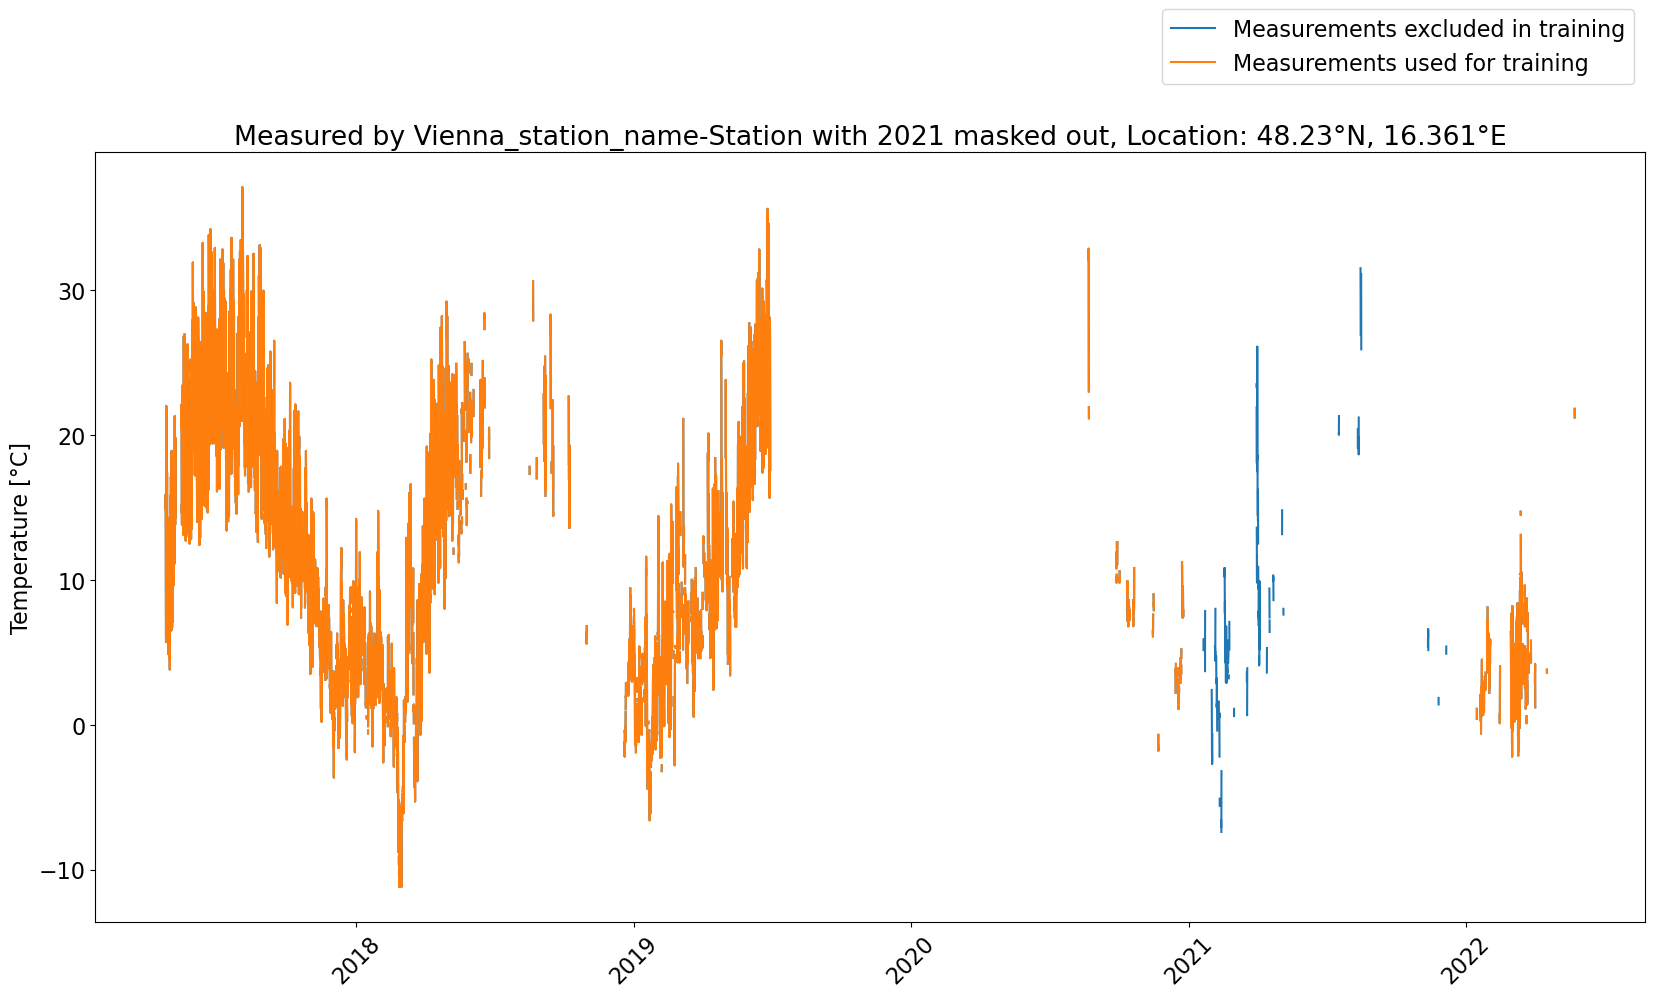

In [6]:
station = StationData(
    name='Vienna_station_name',
    folder_path='measurements/Vienna',
    mask_years=[2021]  # Optionally mask out certain years
)

In [9]:

progress = ProgressStatus()

training = TrainingExecutor_era5(
    station=station,
    iterations=300000,
    progress=progress,
    local=True,
    era5_path="ERA5_DRKZ/vienna_t2m_2017-2024_data.nc"
)




TypeError: 'exist_ok' is an invalid keyword argument for mkdir()

In [22]:
import os

source_path = "ERA5_DRKZ/vienna_t2m_2017-2024_data.nc"
print(f"Does the source ERA5 file exist? {os.path.isfile(source_path)}")

Does the source ERA5 file exist? True


In [2]:
progress = ProgressStatus()


training = TrainingExecutor_era5(
    station = station,
    iterations = 300000,
    progress= progress,
    local = True,
    era5_path="ERA5_DRKZ/vienna_t2m_2017-2024_data.nc"
)
job_id = training.execute_with_sbatch()

NameError: name 'ProgressStatus' is not defined

In [1]:
import time
job_id = training.execute()
print(f"Training started. Job ID/Path: {job_id}")

# Monitor Training Progress (Optional)
while training.is_running():
    current_phase = progress.current_phase
    percentage = progress.percentage_complete
    print(f"Phase: {current_phase}, Progress: {percentage:.2f}%")
    time.sleep(10)  # Check every 10 seconds

# Retrieve Trained Model
if training.local:
    trained_model_zip_path = job_id  # Path to the zip file
    extract_path = "/path/to/extract/"
    
    # Ensure the extraction path exists
    os.makedirs(extract_path, exist_ok=True)
    
    # Extract the zip file
    with zipfile.ZipFile(trained_model_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    
    print(f"Trained model extracted to {extract_path}")
else:
    print(f"Training submitted to SLURM with Job ID: {job_id}")
    # Additional steps to retrieve model from SLURM-managed storage

NameError: name 'training' is not defined

In [6]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Execute training
job_id = training.execute()
logging.info(f"Training started. Job ID/Path: {job_id}")


/var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/ipykernel_50789/909724827.py:6: RuntimeWarning: coroutine 'TrainingExecutor_era5.execute' was never awaited
  job_id = training.execute()
2024-11-04 13:30:50,545 - INFO - Training started. Job ID/Path: <coroutine object TrainingExecutor_era5.execute at 0x31bb80f90>


In [ ]:
station_submission = DataSubmission(name=vienna_station, mask_years=2021)
station_submission.measurement_dir_path = measurements_folder

station_submission.initialize_station()

In [ ]:
from station.station import StationData
from era5.era5_download_hook import Era5DownloadHook
from era5.era5_downloader import DownloadEra5ForStation
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc
from era5.era5_downloader import Era5ForStationCropper

# Step 1: Initialize StationData
station = StationData(
    name='MyStation',
    folder_path='/path/to/station_data',
    mask_years=[]
)

# Step 2: Initialize ERA5 Download Hook
era5_hook = Era5DownloadHook(
    lat=station.metadata['latitude'],
    lon=station.metadata['longitude']
)

# Step 3: Download ERA5 Data
grib_dir_path = '/path/to/grib/files'
era5_downloader = DownloadEra5ForStation(
    station=station,
    grib_dir_path=grib_dir_path,
    hook=era5_hook
)

# Step 4: Convert and Merge GRIB Files to NetCDF
era5_nc_path = '/path/to/era5.nc'
era5_converter = Era5DataFromGribToNc(
    folder_path=grib_dir_path,
    era5_target_file_path=era5_nc_path
)

# Step 5: Crop ERA5 Data to Match Station Data
era5_cropped_path = '/path/to/era5_cropped.nc'
era5_cropper = Era5ForStationCropper(
    station=station,
    era5_path=era5_nc_path,
    era5_target_path=era5_cropped_path
)
era5_cropper.execute()

# Now you can proceed with your analysis using 'station' and 'era5_cropped_path'


In [ ]:
from station.station import StationData
from era5.era5_download_hook import Era5DownloadHook
from era5.era5_downloader import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc
from era5.era5_downloader import Era5ForStationCropper

# Step 1: Initialize StationData
station = StationData(
    name='MyStation',
    folder_path='/path/to/station_data',
    mask_years=[]  # Specify years to exclude if any
)

# Step 2: Find Missing Hours
missing_hours = station.find_gaps()
print(f"Missing hours: {missing_hours}")

# Step 3: Get Available Months
years_by_month = station.get_all_months_in_df()
print(f"Available months by year: {years_by_month}")

# Step 4: Export Station Data to NetCDF
station_nc_path = station.export_as_nc(target_directory='/path/to/save/nc_files')
print(f"Station data exported to: {station_nc_path}")

# Step 5: Initialize ERA5 Download Hook
era5_hook = Era5DownloadHook(
    lat=station.metadata['latitude'],
    lon=station.metadata['longitude']
)

# Step 6: Download ERA5 Data
grib_dir_path = '/path/to/grib/files'

# Option A: Download All ERA5 Data
era5_downloader = DownloadEra5ForStation(
    station=station,
    grib_dir_path=grib_dir_path,
    hook=era5_hook
)

# Option B: Download Only Missing ERA5 Data (Uncomment if needed)
# era5_gap_downloader = DownloadEra5ForStationGaps(
#     station=station,
#     grib_dir_path=grib_dir_path,
#     hook=era5_hook
# )

# Step 7: Convert and Merge GRIB Files to NetCDF
era5_nc_path = '/path/to/era5.nc'
era5_converter = Era5DataFromGribToNc(
    folder_path=grib_dir_path,
    era5_target_file_path=era5_nc_path
)

# Step 8: Crop ERA5 Data to Match Station Data
era5_cropped_path = '/path/to/era5_cropped.nc'
era5_cropper = Era5ForStationCropper(
    station=station,
    era5_path=era5_nc_path,
    era5_target_path=era5_cropped_path
)
era5_cropper.execute()

# Now, both station data (in NetCDF format) and ERA5 data (cropped) are ready for analysis.


In [ ]:
from station.station import StationData
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Initialize StationData
station = StationData(
    name='ViennaStation',
    folder_path='/path/to/vienna_station_data',
    mask_years=[2020]  # Example: Mask out the year 2020
)

# Step 2: Identify Missing Data Gaps
missing_hours = station.find_gaps()
print(f"Number of missing hours: {len(missing_hours)}")

# Load ERA5 data
cropped_era5_nc_path = '/path/to/cropped_era5.nc'
era5_data = xr.open_dataset(cropped_era5_nc_path)

# Step 3: Extract ERA5 Data for Missing Hours
if missing_hours:
    missing_times = pd.to_datetime(missing_hours)
    # Ensure ERA5 data covers the missing times
    valid_missing_times = missing_times[(missing_times >= era5_data.time.min().values) &
                                       (missing_times <= era5_data.time.max().values)]
    if not valid_missing_times.empty:
        missing_era5_data = era5_data.sel(time=valid_missing_times, method='nearest')
        print("Extracted ERA5 data for missing hours:")
        print(missing_era5_data)
        
        # Convert ERA5 temperature to Celsius
        era5_t2m_celsius = missing_era5_data['t2m'] - 273.15
        
        # Align with station DataFrame
        station_df = station.df.copy()
        station_df, era5_t2m_celsius = station_df.align(era5_t2m_celsius, join='left')
        
        # Fill NaN values in station data with ERA5 data
        station_df['tas_filled'] = station_df['tas'].fillna(era5_t2m_celsius)
        
        # Update the station DataFrame
        station.df = station_df
        
        # Verify filling
        print(station.df[['tas', 'tas_filled']].head())
    else:
        print("No valid missing times within the ERA5 data range.")
else:
    print("No missing hours found in station data.")

# Step 4: Retrieve Available Months
years_by_months = station.get_all_months_in_df()
print("Available Months by Year:", years_by_months)

# Step 5: Export Filled Station Data to NetCDF
target_dir = '/path/to/exported_nc_files'
filled_nc_file_path = station.export_as_nc(target_directory=target_dir)
print(f"Filled station data exported to: {filled_nc_file_path}")

# Step 6: Visualize Original vs. Filled Data
plt.figure(figsize=(15, 5))
plt.plot(station.df.index, station.df['tas'], label='Original Station Data')
plt.plot(station.df.index, station.df['tas_filled'], label='Filled Station Data', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Station Temperature Data: Original vs. Filled')
plt.legend()
plt.show()
